Comparador de investimentos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact  
import datetime
from workadays import workdays as wd
#%matplotlib widget

In [2]:
# a taxa di precisa estar atualizada
taxaDI = 0.1125
C = (1+taxaDI)**(1/252) - 1

In [48]:
# entradas da aplicação
a = datetime.date.today()
b = a+datetime.timedelta(days=365)

def contador(a, b):
    N = (b-a).days
    n = wd.networkdays(a, b)
    return N, n

In [49]:
def imposto(N):
    if N<=180:
        return 0.225
    elif N<=360:
        return 0.20
    elif N<=720:
        return 0.175
    else:
        return 0.15

In [50]:
@np.vectorize
def R_CDB(a, b, P):
    N, n = contador(a, b)
    rendimento = 100*( ((C*0.01*P + 1)**n - 1) * (1-imposto(N)) )
    return rendimento

@np.vectorize
def R_LCI(a, b, P):
    N, n = contador(a, b)
    return 100*((C*0.01*P + 1)**n - 1)

@np.vectorize
def P_LCI(a, b, P_CDB):
    N, n = contador(a, b)
    return 100*((( ((C*0.01*P_CDB+1)**n -1)*(1-imposto(N))) + 1)**(1/n) -1) / C

@np.vectorize
def P_CDB(a, b, P_LCI):
    N, n = contador(a, b)
    return 100*( (((C*0.01*P_LCI+1)**n - 1)/(1-imposto(N)) + 1 )**(1/n) -1) / C



In [51]:
R_CDB(a, b, 110)

array(10.30790987)

In [52]:
R_LCI(a, b, 92)

array(10.34833216)

In [66]:
P_LCI(a, b, 130)

array(108.51170022)

In [9]:
P_CDB(a, b, 109.5)

array(126.42900977)

In [10]:
tempo = pd.date_range(a, b)
dias = [tempo[i].date() for i in range(len(tempo))][1:]

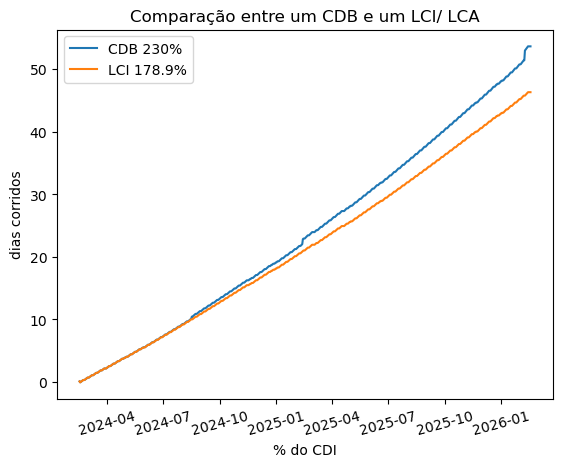

In [69]:
fig, ax = plt.subplots()

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=15)
        
cdb = 230
lci = 178.9

ax.plot(dias, R_CDB(a, dias, cdb), label=f'CDB {cdb}%')
ax.plot(dias, R_LCI(a, dias, lci), label=f'LCI {lci}%')
ax.set_title('Comparação entre um CDB e um LCI/ LCA')
ax.set_xlabel('% do CDI')
ax.set_ylabel('dias corridos')
ax.legend(loc='upper left', ncols=1)




In [12]:
dados = pd.DataFrame()
x = np.array(range(100, 230))
dados['CDB'] = [x[i] for i in range(len(x))]
dados['LCI/ LCA'] = (P_LCI(a, b, x)).round()

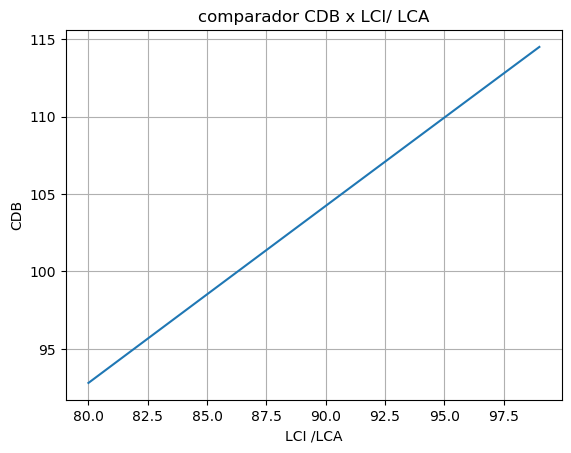

In [13]:
fig, ax = plt.subplots()
ax.grid()

ax.set_title('comparador CDB x LCI/ LCA')
ax.set_xlabel('LCI /LCA')
ax.set_ylabel('CDB')

x = range(80, 100)

ax.plot(x,
        P_CDB(a, b, x),
        label='CDB')

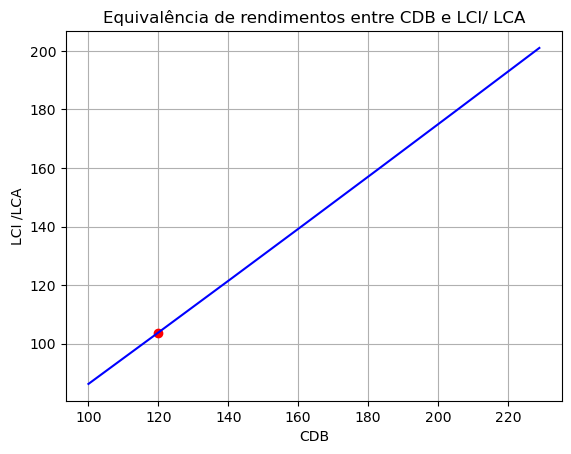

In [33]:
fig, ax = plt.subplots()
ax.grid()

ax.set_title('Equivalência de rendimentos entre CDB e LCI/ LCA')
ax.set_xlabel('CDB')
ax.set_ylabel('LCI /LCA')
ax.set_axisbelow(True)

xmin = 100
xmax = 230
x = range(xmin, xmax)

ax.plot(x,
        P_LCI(a, b, x),
        label='LCI',
        color = 'blue'
       )

ax.scatter(120
    ,P_LCI(a, b, 120),
    marker='o',
    color='red',
    label='cursor',
        )

In [15]:
#dados[0:50]

In [38]:
a+datetime.timedelta(days=365)

datetime.date(2025, 2, 15)

In [40]:
datetime.date.today()

datetime.date(2024, 2, 18)

In [47]:
datetime.date.today()+datetime.timedelta(days=365)

datetime.date(2025, 2, 17)